In [71]:
import argparse
import os
import torch
import pyro
import json
import math
import scipy
from tqdm import tqdm
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import PyroOptim
from pyro.optim import Adam
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from scipy.sparse import csr_matrix
from scipy.spatial import KDTree
import seaborn as sns

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import lightning as L
import torch.nn.functional as F
from torch.utils.data import DataLoader

import subprocess
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *
from utils.BayesSpace import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import GPUtil

In [72]:
if torch.cuda.is_available():
    print("YAY! GPU available :3")
    
    # Get all available GPUs sorted by memory usage (lowest first)
    available_gpus = GPUtil.getAvailable(order='memory', limit=1)
    
    if available_gpus:
        selected_gpu = available_gpus[0]
        
        # Set the GPU with the lowest memory usage
        torch.cuda.set_device(selected_gpu)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        
        print(f"Using GPU: {selected_gpu} with the lowest memory usage.")
    else:
        print("No GPUs available with low memory usage.")
else:
    print("No GPU available :(")

YAY! GPU available :3
Using GPU: 3 with the lowest memory usage.


# Synthetic Data Generation

In [76]:
def prepare_synthetic_data(
    grid_size = 50,
    num_clusters = 5,
    data_dimension = 5,
    random_seed = 1,
    r = 1
):

    # Set grid dimensions and random seed
    np.random.seed(random_seed)

    # Step 1: Initialize an empty grid and randomly assign cluster "patches"
    ground_truth = np.zeros((grid_size, grid_size), dtype=int)
    for cluster_id in range(1, num_clusters):
        # Randomly choose a center for each cluster
        center_x, center_y = np.random.randint(0, grid_size, size=2)
        radius = np.random.randint(10, 30)  # Random radius for each cluster region

        # Assign cluster_id to a circular region around the chosen center
        for i in range(grid_size):
            for j in range(grid_size):
                if (i - center_x) ** 2 + (j - center_y) ** 2 < radius ** 2:
                    ground_truth[i, j] = cluster_id

    # Step 2: Add random noise within each patch
    noise_level = 0.5
    noisy_grid = ground_truth + noise_level * np.random.randn(grid_size, grid_size)

    # Step 3: Apply Gaussian smoothing to create spatial clustering
    sigma = 3  # Controls the amount of clustering smoothness
    smoothed_grid = scipy.ndimage.gaussian_filter(noisy_grid, sigma=sigma)

    # Step 4: Threshold to obtain integer values
    clustered_grid = np.round(smoothed_grid).astype(int)
    clustered_grid = np.clip(clustered_grid, 0, num_clusters)

    # Plot the clustered grid with flipped y axis
    fig, ax = plt.subplots(figsize=(6, 6)) 
    ax.imshow(clustered_grid, cmap="tab20", interpolation="nearest", origin='lower')  # Flip y axis by setting origin to 'lower'
    ax.set_title("Ground Truth Clusters")
    plt.colorbar(ax.imshow(clustered_grid, cmap="rainbow", interpolation="nearest", origin='lower'), ax=ax, label="Cluster Level", ticks=range(num_clusters + 1))  # Flip y axis by setting origin to 'lower'
    import os
    os.makedirs("results/SYNTHETIC", exist_ok=True)
    plt.savefig("results/SYNTHETIC/ground_truth.png")
    
    plt.show()

    def find_indices_within_distance(grid, r=1):
        indices_within_distance = np.empty((grid.shape[0], grid.shape[1]), dtype=object)
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                # Check all neighboring cells within a Manhattan distance of 1
                neighbors = []
                for x in range(max(0, i-r), min(grid.shape[0], i+r+1)):
                    for y in range(max(0, j-r), min(grid.shape[1], j+r+1)):
                        if abs(x - i) + abs(y - j) <= r:
                            neighbors.append((x, y))
                indices_within_distance[i, j] = neighbors
        return indices_within_distance

    # get the rook neighbors for each spot
    indices = find_indices_within_distance(clustered_grid, r=r)

    prior_weights = np.zeros((clustered_grid.shape[0] * clustered_grid.shape[1], num_clusters))

    # for each spot sample 
    for i in range(clustered_grid.shape[0]):
        for j in range(clustered_grid.shape[1]):
            for neighbor in indices[i, j]:
                prior_weights[i * clustered_grid.shape[1] + j, clustered_grid[neighbor]] += 1
    prior_weights = prior_weights / prior_weights.sum(axis=1, keepdims=True)

    # Initialize lists for means, covariances, and data points
    means = []
    covariances = []
    data = np.empty((clustered_grid.shape[0] * clustered_grid.shape[1], data_dimension))

    # Generate means and covariances for each cluster
    for i in range(num_clusters):
        # Randomly set the mean close to the origin to encourage overlap
        mean = np.random.uniform(-5, 5, data_dimension)
        # Generate a diagonal covariance matrix with random magnitudes
        covariance = np.diag(np.random.rand(data_dimension) * 2.5)
        
        means.append(mean)
        covariances.append(covariance)

    for mean, covariance in zip(means, covariances):
        print(mean, covariance)
        
    # Generate samples from the mixture.
    for i, weights in enumerate(prior_weights):
        data[i] = np.sum(weights[k] * np.random.multivariate_normal(means[k], covariances[k], 1) for k in range(num_clusters))

    # Create an anndata object
    adata = ad.AnnData(data)

    # Add row and col index
    adata.obs['spot_number'] = np.arange(clustered_grid.shape[0] * clustered_grid.shape[1])
    adata.obs['spot_number'] = adata.obs['spot_number'].astype('category')
    adata.obs['row'] = np.repeat(np.arange(clustered_grid.shape[0]), clustered_grid.shape[1])
    adata.obs['col'] = np.tile(np.arange(clustered_grid.shape[1]), clustered_grid.shape[0])
    clustering = XeniumCluster(data=adata.X, dataset_name="SYNTHETIC")
    clustering.xenium_spot_data = adata

    Xenium_to_BayesSpace(clustering.xenium_spot_data, dataset_name="SYNTHETIC", spot_size=grid_size)

    return clustering.xenium_spot_data.X, clustering.xenium_spot_data.obs[['row', 'col']], clustering, prior_weights

def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    clustering.pca(clustering.xenium_spot_data, num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]

    return data, spatial_locations, clustering

def prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=100, 
        third_dim=False, 
        log_normalize=True,
        likelihood_mode="PCA",
        num_pcs=5,
        hvg_var_prop=0.5,
        min_expressions_per_spot=10
    ):

    data_filepath = f"data/spot_data/{dataset}/hBreast_SPOTSIZE={spot_size}um_z={third_dim}.h5ad"
    
    if spots:

        if os.path.exists(data_filepath):

            clustering = XeniumCluster(data=None, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)
            print("Loading data.")
            clustering.xenium_spot_data = ad.read_h5ad(data_filepath)

        else:

            # Path to your .gz file
            file_path = f'data/{dataset}/transcripts.csv.gz'

            # Read the gzipped CSV file into a DataFrame
            df_transcripts = pd.read_csv(file_path, compression='gzip')
            df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
            df_transcripts.head(), df_transcripts.shape

            # drop cells without ids
            df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

            # drop blanks and controls
            df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

            clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)

            if not os.path.exists(data_filepath):
                print("Generating and saving data")
                clustering.create_spot_data(third_dim=third_dim, save_data=True)
                clustering.xenium_spot_data.write_h5ad(data_filepath)

        print("Number of spots: ", clustering.xenium_spot_data.shape[0])
        clustering.xenium_spot_data = clustering.xenium_spot_data[clustering.xenium_spot_data.X.sum(axis=1) > min_expressions_per_spot]
        print("Number of spots after filtering: ", clustering.xenium_spot_data.shape[0])

        if log_normalize:
            clustering.normalize_counts(clustering.xenium_spot_data)

        if likelihood_mode == "PCA":
            clustering.pca(clustering.xenium_spot_data, num_pcs)
            data = clustering.xenium_spot_data.obsm["X_pca"]
        elif likelihood_mode == "HVG":
            min_dispersion = torch.distributions.normal.Normal(0.0, 1.0).icdf(hvg_var_prop)
            clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, flavor="seurat", min_mean=0.0125, max_mean=1000, min_disp=min_dispersion)
            clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
            data = clustering.xenium_spot_data.X
        elif likelihood_mode == "ALL":
            data = clustering.xenium_spot_data.X

        spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
    
    # prepare cells data
    else:

        cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
        cells_pivot = cells.pivot_table(index='cell_id', 
                                        columns='feature_name', 
                                        values='count', 
                                        fill_value=0)
        
        location_means = df_transcripts.groupby('cell_id').agg({
            'x_location': 'mean',
            'y_location': 'mean',
            'z_location': 'mean'
        }).reset_index()

        cells_pivot = location_means.join(cells_pivot, on='cell_id')

        if log_normalize:
            # log normalization
            cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

        if likelihood_mode == "PCA":
            pca = PCA(n_components=num_pcs)
            data = pca.fit_transform(cells_pivot.iloc[:, 4:])

        elif likelihood_mode == "HVG":
            genes = cells_pivot.iloc[:, 4:]
            gene_variances = genes.var(axis=0)
            gene_variances = gene_variances.sort_values(ascending=False)
            gene_var_proportions = (gene_variances / sum(gene_variances))
            relevant_genes = list(gene_var_proportions[(gene_var_proportions.cumsum() < hvg_var_prop)].index)
            cells_pivot.iloc[:, 4:] = cells_pivot.iloc[:, 4:][[relevant_genes]]
            data = cells_pivot.iloc[:, 4:]

        elif likelihood_mode == "ALL":
            data = cells_pivot.iloc[:, 4:]

        spatial_locations = cells_pivot[["x_location", "y_location"]]

    # the last one is to regain var/obs access from original data
    return data, spatial_locations, clustering 

In [74]:
spot_size=250
data_mode="PCA"
num_pcs=3
hvg_var_prop=0.9
dataset_name="SYNTHETIC"
kmeans_init=True
custom_init="Hierarchical"
spatial_init=True
num_clusters=5
batch_size=128
neighborhood_size=2
neighborhood_agg="mean"
concentration_amplification=10.0
# uncertainty_values = [1/num_clusters, 2/num_clusters, 3/num_clusters, 4/num_clusters, 5/num_clusters]
uncertainty_values = [0.25, 0.5, 0.75, 0.9, 0.99]
evaluate_markers=False
spatial_normalize=0.00

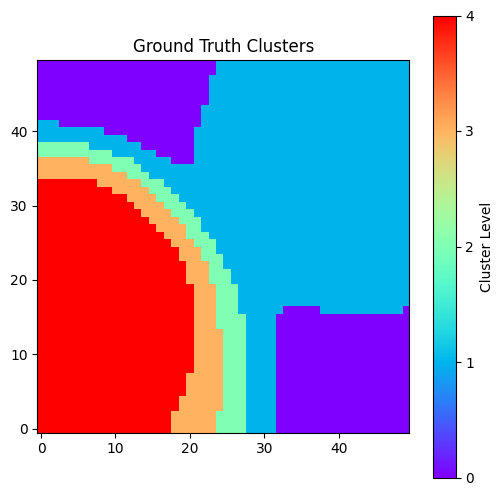

[-1.85535937  4.04186255 -0.95228016  3.08862541  0.81053303] [[2.4887799  0.         0.         0.         0.        ]
 [0.         1.10497931 0.         0.         0.        ]
 [0.         0.         1.26053098 0.         0.        ]
 [0.         0.         0.         0.43709112 0.        ]
 [0.         0.         0.         0.         1.30780163]]
[ 1.01939909  1.81791175 -0.75413555 -2.17643892 -3.61932162] [[2.37373841 0.         0.         0.         0.        ]
 [0.         0.80503623 0.         0.         0.        ]
 [0.         0.         0.05964982 0.         0.        ]
 [0.         0.         0.         0.33034402 0.        ]
 [0.         0.         0.         0.         0.35332062]]
[-2.47550277 -0.45159793  4.55002626 -0.0224897  -4.2889903 ] [[0.59966493 0.         0.         0.         0.        ]
 [0.         1.14816772 0.         0.         0.        ]
 [0.         0.         1.98996892 0.         0.        ]
 [0.         0.         0.         0.7057492  0.        ]


,row,col
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
2495,49,45
2496,49,46
2497,49,47
2498,49,48


In [75]:
gene_data, spatial_locations, original_adata, TRUE_WEIGHTS = prepare_synthetic_data()
TRUE_ASSIGNMENTS = TRUE_WEIGHTS.argmax(axis=1)
spatial_locations

In [68]:
def save_filepath(model, component, sample_for_assignment=None):

    total_file_path = (
        f"results/{dataset_name}/{model}/{component}/{data_file_path}/"
        f"INIT={custom_init}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={num_clusters}"
        f"/SPATIALINIT={spatial_init}/SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"/SPATIALNORM={spatial_normalize}/SPATIALPRIORMULT={concentration_amplification}/SPOTSIZE={spot_size}/AGG={neighborhood_agg}"
    )

    return total_file_path

In [69]:
def custom_cluster_initialization(original_adata, method, K=17):

    original_adata.generate_neighborhood_graph(original_adata.xenium_spot_data, plot_pcas=False)

    # This function initializes clusters based on the specified method
    if method == "K-Means":
        initial_clusters = original_adata.KMeans(original_adata.xenium_spot_data, save_plot=False, K=K, include_spatial=False)
    elif method == "Hierarchical":
        initial_clusters = original_adata.Hierarchical(original_adata.xenium_spot_data, save_plot=True, num_clusters=K)
    elif method == "Leiden":
        initial_clusters = original_adata.Leiden(original_adata.xenium_spot_data, resolutions=[0.35], save_plot=False, K=K)[0.35]
    elif method == "Louvain":
        initial_clusters = original_adata.Louvain(original_adata.xenium_spot_data, resolutions=[0.35], save_plot=False, K=K)[0.35]
    elif method == "mclust":
        original_adata.pca(original_adata.xenium_spot_data, num_pcs)
        initial_clusters = original_adata.mclust(original_adata.xenium_spot_data, G=K, model_name = "EEE")
    else:
        raise ValueError(f"Unknown method: {method}")

    return initial_clusters

Hierarchical ARI: 0.8965271683562734 NMI: 0.864877452278281


100%|██████████| 2500/2500 [00:00<00:00, 11875.06it/s]


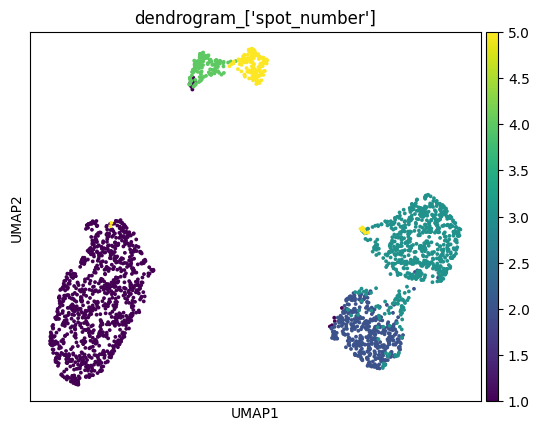

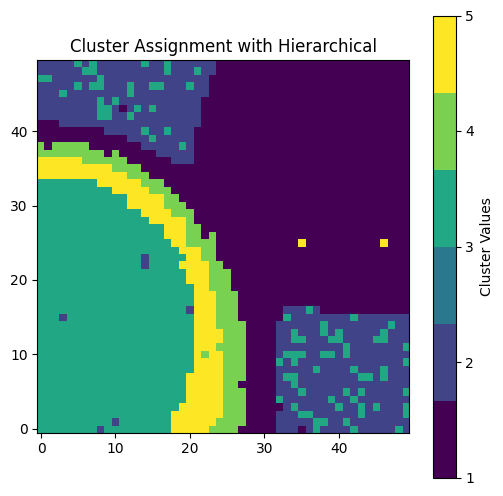

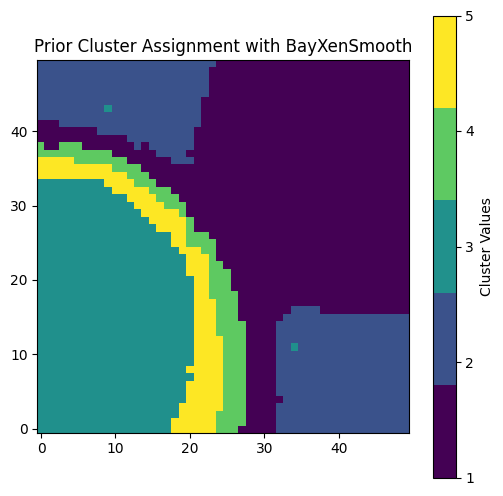

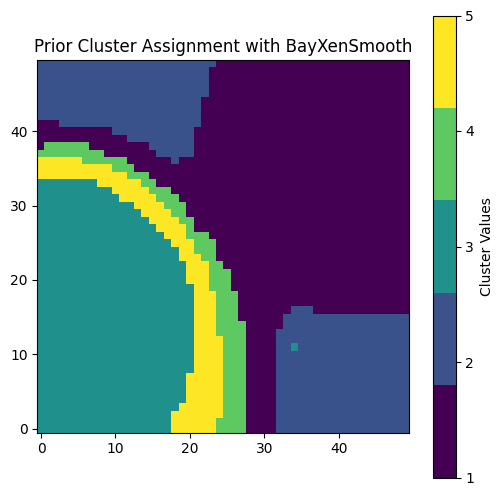

In [70]:
# Clamping
MIN_CONCENTRATION = 0.001

num_posterior_samples = 1000

spatial_init_data = StandardScaler().fit_transform(gene_data)
gene_data = StandardScaler().fit_transform(gene_data)
empirical_prior_means = torch.zeros(num_clusters, spatial_init_data.shape[1])
empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

if custom_init or kmeans_init:

    if custom_init:

        initial_clusters = custom_cluster_initialization(original_adata, custom_init, K=num_clusters)
        print(custom_init, f"ARI: {ARI(initial_clusters, TRUE_ASSIGNMENTS)}", f"NMI: {NMI(initial_clusters, TRUE_ASSIGNMENTS)}")

    elif kmeans_init:

        kmeans_init_data = np.concatenate((spatial_locations, original_adata.xenium_spot_data.X), axis=1)
        kmeans_init_data = StandardScaler().fit_transform(kmeans_init_data)

        if spatial_normalize:

            spatial_dim = spatial_locations.shape[1]
            gene_dim = original_adata.xenium_spot_data.X.shape[1]
            spatial_factor = (gene_dim * spatial_normalize / (spatial_dim * (1 - spatial_normalize))) ** 0.5
            kmeans_init_data[:, :spatial_locations.shape[1]] *= spatial_factor

        kmeans = KMeans(n_clusters=num_clusters).fit(kmeans_init_data)

        initial_clusters = kmeans.predict(kmeans_init_data)

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")
        
    if kmeans_init and not custom_init:

        if not os.path.exists(kmeans_clusters_filepath := save_filepath("KMeans", "clusters")):
            os.makedirs(kmeans_clusters_filepath)
        _ = plt.savefig(
            f"{kmeans_clusters_filepath}/result.png"
        )

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)
        
        cluster_grid[rows, columns] = torch.tensor(initial_clusters, dtype=torch.int) + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colors, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters), label='Cluster Values')
        plt.title('Cluster Assignment with KMeans')

    if dataset_name == "DLPFC":
        # Create a DataFrame for easier handling
        data = pd.DataFrame({
            'ClusterAssignments': initial_clusters,
            'Region': original_adata.xenium_spot_data.obs["Region"]
        })

        # Drop rows where 'Region' is NaN
        filtered_data = data.dropna(subset=['Region'])

        # Calculate ARI and NMI only for the non-NaN entries
        ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        cluster_metrics = {
            "ARI": ari,
            "NMI": nmi
        }

        data_file_path = f"{data_mode}/{num_pcs}"

        if not os.path.exists(kmeans_cluster_metrics_filepath := save_filepath("KMeans", "cluster_metrics")):
            os.makedirs(kmeans_cluster_metrics_filepath)
        with open(f"{kmeans_cluster_metrics_filepath}/mpd.json", 'w') as fp:
            json.dump(cluster_metrics, fp)

    for i in range(num_clusters):
        cluster_data = gene_data[initial_clusters == i]
        if cluster_data.size > 0:  # Check if there are any elements in the cluster_data
            empirical_prior_means[i] = torch.tensor(cluster_data.mean(axis=0))
            empirical_prior_scales[i] = torch.tensor(cluster_data.std(axis=0))
    cluster_probs_prior = torch.zeros((initial_clusters.shape[0], num_clusters))
    cluster_probs_prior[torch.arange(initial_clusters.shape[0]), initial_clusters - 1] = 1.

else:

    cluster_probs_prior = torch.ones((len(gene_data), num_clusters), dtype=float)

locations_tensor = torch.tensor(spatial_locations.to_numpy())

# Compute the number of elements in each dimension
num_spots = cluster_probs_prior.shape[0]

# Initialize an empty tensor for spatial concentration priors
spatial_cluster_probs_prior = torch.zeros_like(cluster_probs_prior, dtype=torch.float64)

spot_locations = KDTree(locations_tensor.cpu())  # Ensure this tensor is in host memory
neighboring_spot_indexes = spot_locations.query_ball_point(locations_tensor.cpu(), r=neighborhood_size, p=1, workers=8)

# Iterate over each spot
for i in tqdm(range(num_spots)):

    # Select priors in the neighborhood
    priors_in_neighborhood = cluster_probs_prior[neighboring_spot_indexes[i]]
    # print(f"Spot {i} has {len(neighboring_spot_indexes[i])} neighbors")
    # print(priors_in_neighborhood)

    # Compute the sum or mean, or apply a custom weighting function
    if neighborhood_agg == "mean":
        neighborhood_priors = priors_in_neighborhood.mean(dim=0)
    else:
        locations = original_adata.xenium_spot_data.obs[["x_location", "y_location", "z_location"]].values
        neighboring_locations = locations[neighboring_spot_indexes[i]].astype(float)
        distances = torch.tensor(np.linalg.norm(neighboring_locations - locations[i], axis=1))
        def distance_weighting(x):
            weight = 1/(1 + x/spot_size)
            # print(weight)
            return weight / weight.sum()
        neighborhood_priors = (priors_in_neighborhood * distance_weighting(distances).reshape(-1, 1)).sum(dim=0)
    # Update the cluster probabilities
    spatial_cluster_probs_prior[i] += neighborhood_priors

spatial_cluster_probs_prior = spatial_cluster_probs_prior.clamp(MIN_CONCENTRATION)
sample_for_assignment_options = [True, False]

num_prior_samples = 100
for sample_for_assignment in sample_for_assignment_options:

    if sample_for_assignment:
        cluster_assignments_prior_TRUE = pyro.sample("cluster_assignments", dist.Categorical(spatial_cluster_probs_prior).expand_by([num_prior_samples])).detach().mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_assignments_prior_FALSE = spatial_cluster_probs_prior.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE

    # Load the data
    data = torch.tensor(gene_data).float()

    cluster_grid_PRIOR = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid_PRIOR[rows, columns] = cluster_assignments_prior + 1

    colors = plt.cm.get_cmap('viridis', num_clusters)

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid_PRIOR.cpu(), cmap=colors, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(1, num_clusters + 1), label='Cluster Values')
    plt.title('Prior Cluster Assignment with BayXenSmooth')

    if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
        os.makedirs(bayxensmooth_clusters_filepath)
    _ = plt.savefig(
        f"{bayxensmooth_clusters_filepath}/prior_result.png"
    )

In [33]:
# grab the mpd distance of cluster labels
mpd = {}
for label in range(1, num_clusters + 1):
    current_cluster_locations = torch.stack(torch.where((cluster_grid_PRIOR.cpu() == label)), axis=1).to(float)
    mpd[f"Cluster {label}"] = spot_size * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
sum(mpd.values()) / 1_000_000

0.023226941601478052

In [34]:
empirical_prior_means_guide = empirical_prior_means.clone().detach()
empirical_prior_scales_guide = empirical_prior_scales.clone().detach()

In [35]:
learn_global_variances = True

In [12]:
torch.set_printoptions(sci_mode=False)
PRIOR_SCALE = np.sqrt(0.1) # higher means weaker
NUM_PARTICLES = 25

expected_total_param_dim = 2 # K x D

def model(data):

    with pyro.plate("clusters", num_clusters):

        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(empirical_prior_means, 1.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(empirical_prior_scales, 0.25).to_event(1))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        mu = torch.log(spatial_cluster_probs_prior[ind])
        cov_matrix = torch.eye(mu.shape[1], dtype=mu.dtype, device=mu.device) * 10.0
        cluster_probs_logits = pyro.sample("cluster_logits", dist.MultivariateNormal(mu, cov_matrix))
        cluster_probs = torch.softmax(cluster_probs_logits, dim=-1)
        # likelihood for batch
        if cluster_means.dim() == expected_total_param_dim:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(0).expand(batch_size, -1, -1), 
                    cluster_scales.unsqueeze(0).expand(batch_size, -1, -1), +
                    cluster_probs
                ), 
                obs=batch_data
            )
        # likelihood for batch WITH vectorization of particles
        else:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_scales.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_probs
                ), 
                obs=batch_data
            )

def guide(data):
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_probs_logits_q_mean = pyro.param("cluster_logits_q_mean", torch.log(spatial_cluster_probs_prior) + torch.randn_like(spatial_cluster_probs_prior) * 0.1)
    cluster_probs_logits_q_scale = pyro.param("cluster_logits_q_scale", torch.ones_like(spatial_cluster_probs_prior, dtype=spatial_cluster_probs_prior.dtype, device=spatial_cluster_probs_prior.device) * 2.5, dist.constraints.positive)

    with pyro.plate("clusters", num_clusters):
        # Global variational parameters for means and scales
        cluster_means_q_mean = pyro.param("cluster_means_q_mean", empirical_prior_means + torch.randn_like(empirical_prior_means) * 0.05)
        cluster_scales_q_mean = pyro.param("cluster_scales_q_mean", empirical_prior_scales + torch.randn_like(empirical_prior_scales) * 0.01, constraint=dist.constraints.positive)
        if learn_global_variances:
            cluster_means_q_scale = pyro.param("cluster_means_q_scale", torch.ones_like(empirical_prior_means) * 1.0, constraint=dist.constraints.positive)
            cluster_scales_q_scale = pyro.param("cluster_scales_q_scale", torch.ones_like(empirical_prior_scales) * 0.25, constraint=dist.constraints.positive)
            cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q_mean, cluster_means_q_scale).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q_mean, cluster_scales_q_scale).to_event(1))
        else:
            cluster_means = pyro.sample("cluster_means", dist.Delta(cluster_means_q_mean).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.Delta(cluster_scales_q_mean).to_event(1))

    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:

        batch_probs_logits_q_mean = cluster_probs_logits_q_mean[ind]
        batch_probs_logits_q_scale = cluster_probs_logits_q_scale[ind]
        logits = pyro.sample("cluster_logits", dist.Normal(batch_probs_logits_q_mean, batch_probs_logits_q_scale).to_event(1))
        cluster_probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities

In [13]:
empirical_prior_means.shape, empirical_prior_scales.shape

(torch.Size([5, 5]), torch.Size([5, 5]))

In [14]:
print(pyro.render_model(model, model_args=(data,), render_distributions=True, render_params=True))

digraph {
	subgraph cluster_clusters {
		label=clusters labeljust=r labelloc=b
		cluster_means [label=cluster_means fillcolor=white shape=ellipse style=filled]
		cluster_scales [label=cluster_scales fillcolor=white shape=ellipse style=filled]
	}
	subgraph cluster_data {
		label=data labeljust=r labelloc=b
		cluster_logits [label=cluster_logits fillcolor=white shape=ellipse style=filled]
		obs [label=obs fillcolor=gray shape=ellipse style=filled]
	}
	cluster_means -> obs
	cluster_scales -> obs
	cluster_logits -> obs
	distribution_description_node [label="cluster_means ~ Normal\lcluster_scales ~ LogNormal\lcluster_logits ~ MultivariateNormal\lobs ~ MixtureOfDiagNormals\l" shape=plaintext]
}



In [15]:
pyro.clear_param_store()
NUM_EPOCHS = 1000
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

def per_param_callable(param_name):
    if param_name == 'cluster_means_q_mean':
        return {"lr": 0.01, "betas": (0.9, 0.999)}
    elif param_name == 'cluster_scales_q_mean':
        return {"lr": 0.01, "betas": (0.9, 0.999)}
    elif "logit" in param_name:
        return {"lr": 0.01, "betas": (0.9, 0.999)}
    else:
        return {"lr": 0.005, "betas": (0.9, 0.999)}

scheduler = Adam(per_param_callable)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO(num_particles=NUM_PARTICLES, vectorize_particles=True))

# Create a DataLoader for the data
# Convert data to CUDA tensors before creating the DataLoader
data = data.to('cuda')

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

epoch_pbar = tqdm(range(NUM_EPOCHS))
cluster_means_trace = []
cluster_scales_trace = []
current_min_loss = float('inf')
PATIENCE = 15
patience_counter = 0
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_pbar.set_description(f"Epoch {epoch}")
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
        # running_loss += (loss + SPATIAL_PENALTY_WEIGHT * spatial_penalty()) / batch_size
    # svi.optim.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch} : loss = {round(running_loss, 4)}")
        current_cluster_means = pyro.param("cluster_means_q_mean").detach().cpu().numpy()
        cluster_means_trace.append(current_cluster_means)
        current_cluster_scales = pyro.param("cluster_scales_q_mean").detach().cpu().numpy()
        cluster_scales_trace.append(current_cluster_scales)
        # print(current_cluster_means[0])
        if running_loss > current_min_loss:
            patience_counter += 1
        else:
            current_min_loss = running_loss
            patience_counter = 0
        if patience_counter >= PATIENCE:
            break 
        l2_norm = torch.norm(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1) - spatial_cluster_probs_prior, p=2)
        # print(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1)[0])

        if dataset_name == "DLPFC":
            # Create a DataFrame for easier handling
            cluster_data = pd.DataFrame({
                'ClusterAssignments': cluster_assignments_q,
                'Region': original_adata.xenium_spot_data.obs["Region"]
            })

            # Drop rows where 'Region' is NaN
            filtered_data = cluster_data.dropna(subset=['Region'])

            # Calculate ARI and NMI only for the non-NaN entries
            ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
            nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
            print(f"Epoch {epoch} : ARI = {ari} NMI = {nmi}")

        elif dataset_name == "SYNTHETIC":
            num_posterior_samples = 1000
            sample_for_assignment_options = [True, False]
            for sample_for_assignment in sample_for_assignment_options:
                cluster_logits_q_mean = pyro.param("cluster_logits_q_mean")
                cluster_logits_q_scale = pyro.param("cluster_logits_q_scale")
                if sample_for_assignment:
                    cluster_probs_q = torch.softmax(pyro.sample("cluster_probs", dist.Normal(cluster_logits_q_mean, cluster_logits_q_scale).expand_by([num_posterior_samples]).to_event(1)).mean(dim=0), dim=-1)
                    cluster_assignments_q = pyro.sample("cluster_assignments", dist.Categorical(cluster_probs_q).expand_by([num_posterior_samples])).mode(dim=0).values
                    cluster_assignments_prior = cluster_assignments_prior_TRUE
                else:
                    cluster_probs_q = torch.softmax(cluster_logits_q_mean, dim=-1)
                    cluster_assignments_q = cluster_probs_q.argmax(dim=1)
                    cluster_assignments_prior = cluster_assignments_prior_FALSE
                # Detach tensors and convert them to numpy before calling ARI and NMI functions
                cluster_assignments_q_np = cluster_assignments_q.detach().cpu().numpy()
                ari = ARI(cluster_assignments_q_np, TRUE_ASSIGNMENTS)
                nmi = NMI(cluster_assignments_q_np, TRUE_ASSIGNMENTS)
                print(f"Epoch {epoch}, {sample_for_assignment} : ARI = {round(ari, 2)} NMI = {round(nmi, 2)}")

Epoch 2:   0%|          | 0/1000 [00:01<?, ?it/s]

Epoch 1 : loss = 3732.9763
Epoch 1, True : ARI = 0.98 NMI = 0.95
Epoch 1, False : ARI = 0.98 NMI = 0.96


Epoch 3:   0%|          | 0/1000 [00:01<?, ?it/s]

Epoch 2 : loss = 3527.6358
Epoch 2, True : ARI = 0.97 NMI = 0.94
Epoch 2, False : ARI = 0.97 NMI = 0.95


Epoch 4:   0%|          | 0/1000 [00:01<?, ?it/s]

Epoch 3 : loss = 3374.9459
Epoch 3, True : ARI = 0.97 NMI = 0.95
Epoch 3, False : ARI = 0.97 NMI = 0.95


Epoch 5:   0%|          | 0/1000 [00:02<?, ?it/s]

Epoch 4 : loss = 3243.5621
Epoch 4, True : ARI = 0.97 NMI = 0.95
Epoch 4, False : ARI = 0.97 NMI = 0.95


Epoch 6:   0%|          | 0/1000 [00:02<?, ?it/s]

Epoch 5 : loss = 3144.5596
Epoch 5, True : ARI = 0.97 NMI = 0.94
Epoch 5, False : ARI = 0.97 NMI = 0.95


Epoch 7:   0%|          | 0/1000 [00:03<?, ?it/s]

Epoch 6 : loss = 3057.8882
Epoch 6, True : ARI = 0.96 NMI = 0.94
Epoch 6, False : ARI = 0.97 NMI = 0.95


Epoch 8:   0%|          | 0/1000 [00:03<?, ?it/s]

Epoch 7 : loss = 2990.845
Epoch 7, True : ARI = 0.97 NMI = 0.94
Epoch 7, False : ARI = 0.97 NMI = 0.95


Epoch 9:   0%|          | 0/1000 [00:03<?, ?it/s]

Epoch 8 : loss = 2939.5405
Epoch 8, True : ARI = 0.97 NMI = 0.94
Epoch 8, False : ARI = 0.97 NMI = 0.95


Epoch 10:   0%|          | 0/1000 [00:04<?, ?it/s]

Epoch 9 : loss = 2888.6186
Epoch 9, True : ARI = 0.97 NMI = 0.94
Epoch 9, False : ARI = 0.97 NMI = 0.96


Epoch 11:   0%|          | 0/1000 [00:04<?, ?it/s]

Epoch 10 : loss = 2847.4703
Epoch 10, True : ARI = 0.96 NMI = 0.94
Epoch 10, False : ARI = 0.97 NMI = 0.95


Epoch 12:   0%|          | 0/1000 [00:04<?, ?it/s]

Epoch 11 : loss = 2786.8472
Epoch 11, True : ARI = 0.97 NMI = 0.95
Epoch 11, False : ARI = 0.97 NMI = 0.95


Epoch 13:   0%|          | 0/1000 [00:05<?, ?it/s]

Epoch 12 : loss = 2764.1896
Epoch 12, True : ARI = 0.97 NMI = 0.94
Epoch 12, False : ARI = 0.98 NMI = 0.95


Epoch 14:   0%|          | 0/1000 [00:05<?, ?it/s]

Epoch 13 : loss = 2725.5465
Epoch 13, True : ARI = 0.97 NMI = 0.94
Epoch 13, False : ARI = 0.98 NMI = 0.95


Epoch 15:   0%|          | 0/1000 [00:06<?, ?it/s]

Epoch 14 : loss = 2685.5538
Epoch 14, True : ARI = 0.98 NMI = 0.95
Epoch 14, False : ARI = 0.98 NMI = 0.95


Epoch 16:   0%|          | 0/1000 [00:06<?, ?it/s]

Epoch 15 : loss = 2655.7699
Epoch 15, True : ARI = 0.98 NMI = 0.95
Epoch 15, False : ARI = 0.98 NMI = 0.96


Epoch 17:   0%|          | 0/1000 [00:06<?, ?it/s]

Epoch 16 : loss = 2618.3681
Epoch 16, True : ARI = 0.98 NMI = 0.96
Epoch 16, False : ARI = 0.99 NMI = 0.96


Epoch 18:   0%|          | 0/1000 [00:07<?, ?it/s]

Epoch 17 : loss = 2617.6767
Epoch 17, True : ARI = 0.98 NMI = 0.95
Epoch 17, False : ARI = 0.99 NMI = 0.96


Epoch 19:   0%|          | 0/1000 [00:07<?, ?it/s]

Epoch 18 : loss = 2593.31
Epoch 18, True : ARI = 0.98 NMI = 0.95
Epoch 18, False : ARI = 0.98 NMI = 0.96


Epoch 20:   0%|          | 0/1000 [00:08<?, ?it/s]

Epoch 19 : loss = 2578.9648
Epoch 19, True : ARI = 0.98 NMI = 0.95
Epoch 19, False : ARI = 0.98 NMI = 0.96


Epoch 21:   0%|          | 0/1000 [00:08<?, ?it/s]

Epoch 20 : loss = 2571.161
Epoch 20, True : ARI = 0.98 NMI = 0.95
Epoch 20, False : ARI = 0.98 NMI = 0.96


Epoch 22:   0%|          | 0/1000 [00:08<?, ?it/s]

Epoch 21 : loss = 2578.9119
Epoch 21, True : ARI = 0.98 NMI = 0.95
Epoch 21, False : ARI = 0.98 NMI = 0.96


Epoch 23:   0%|          | 0/1000 [00:09<?, ?it/s]

Epoch 22 : loss = 2555.8375
Epoch 22, True : ARI = 0.98 NMI = 0.95
Epoch 22, False : ARI = 0.98 NMI = 0.96


Epoch 24:   0%|          | 0/1000 [00:09<?, ?it/s]

Epoch 23 : loss = 2540.1654
Epoch 23, True : ARI = 0.98 NMI = 0.95
Epoch 23, False : ARI = 0.98 NMI = 0.96


Epoch 25:   0%|          | 0/1000 [00:09<?, ?it/s]

Epoch 24 : loss = 2541.423
Epoch 24, True : ARI = 0.98 NMI = 0.95
Epoch 24, False : ARI = 0.98 NMI = 0.96


Epoch 26:   0%|          | 0/1000 [00:10<?, ?it/s]

Epoch 25 : loss = 2521.0607
Epoch 25, True : ARI = 0.98 NMI = 0.95
Epoch 25, False : ARI = 0.98 NMI = 0.96


Epoch 27:   0%|          | 0/1000 [00:10<?, ?it/s]

Epoch 26 : loss = 2527.1723
Epoch 26, True : ARI = 0.98 NMI = 0.95
Epoch 26, False : ARI = 0.98 NMI = 0.96


Epoch 28:   0%|          | 0/1000 [00:11<?, ?it/s]

Epoch 27 : loss = 2520.7637
Epoch 27, True : ARI = 0.98 NMI = 0.95
Epoch 27, False : ARI = 0.98 NMI = 0.96


Epoch 29:   0%|          | 0/1000 [00:11<?, ?it/s]

Epoch 28 : loss = 2514.4092
Epoch 28, True : ARI = 0.98 NMI = 0.95
Epoch 28, False : ARI = 0.98 NMI = 0.96


Epoch 30:   0%|          | 0/1000 [00:11<?, ?it/s]

Epoch 29 : loss = 2508.7822
Epoch 29, True : ARI = 0.98 NMI = 0.95
Epoch 29, False : ARI = 0.98 NMI = 0.96


Epoch 31:   0%|          | 0/1000 [00:12<?, ?it/s]

Epoch 30 : loss = 2504.2279
Epoch 30, True : ARI = 0.98 NMI = 0.95
Epoch 30, False : ARI = 0.98 NMI = 0.96


Epoch 32:   0%|          | 0/1000 [00:12<?, ?it/s]

Epoch 31 : loss = 2504.5105
Epoch 31, True : ARI = 0.98 NMI = 0.95
Epoch 31, False : ARI = 0.98 NMI = 0.96


Epoch 33:   0%|          | 0/1000 [00:13<?, ?it/s]

Epoch 32 : loss = 2495.8483
Epoch 32, True : ARI = 0.98 NMI = 0.95
Epoch 32, False : ARI = 0.98 NMI = 0.95


Epoch 34:   0%|          | 0/1000 [00:13<?, ?it/s]

Epoch 33 : loss = 2489.6233
Epoch 33, True : ARI = 0.98 NMI = 0.95
Epoch 33, False : ARI = 0.98 NMI = 0.95


Epoch 35:   0%|          | 0/1000 [00:13<?, ?it/s]

Epoch 34 : loss = 2497.2899
Epoch 34, True : ARI = 0.98 NMI = 0.95
Epoch 34, False : ARI = 0.98 NMI = 0.95


Epoch 36:   0%|          | 0/1000 [00:14<?, ?it/s]

Epoch 35 : loss = 2480.5178
Epoch 35, True : ARI = 0.97 NMI = 0.94
Epoch 35, False : ARI = 0.98 NMI = 0.95


Epoch 37:   0%|          | 0/1000 [00:14<?, ?it/s]

Epoch 36 : loss = 2490.6765
Epoch 36, True : ARI = 0.98 NMI = 0.95
Epoch 36, False : ARI = 0.98 NMI = 0.95


Epoch 38:   0%|          | 0/1000 [00:15<?, ?it/s]

Epoch 37 : loss = 2487.3699
Epoch 37, True : ARI = 0.97 NMI = 0.94
Epoch 37, False : ARI = 0.98 NMI = 0.95


Epoch 39:   0%|          | 0/1000 [00:15<?, ?it/s]

Epoch 38 : loss = 2484.3268
Epoch 38, True : ARI = 0.98 NMI = 0.94
Epoch 38, False : ARI = 0.98 NMI = 0.95


Epoch 40:   0%|          | 0/1000 [00:15<?, ?it/s]

Epoch 39 : loss = 2472.4891
Epoch 39, True : ARI = 0.97 NMI = 0.94
Epoch 39, False : ARI = 0.98 NMI = 0.95


Epoch 41:   0%|          | 0/1000 [00:16<?, ?it/s]

Epoch 40 : loss = 2473.1248
Epoch 40, True : ARI = 0.97 NMI = 0.94
Epoch 40, False : ARI = 0.98 NMI = 0.95


Epoch 42:   0%|          | 0/1000 [00:16<?, ?it/s]

Epoch 41 : loss = 2463.9028
Epoch 41, True : ARI = 0.97 NMI = 0.94
Epoch 41, False : ARI = 0.98 NMI = 0.95


Epoch 43:   0%|          | 0/1000 [00:16<?, ?it/s]

Epoch 42 : loss = 2471.7804
Epoch 42, True : ARI = 0.98 NMI = 0.95
Epoch 42, False : ARI = 0.98 NMI = 0.95


Epoch 44:   0%|          | 0/1000 [00:17<?, ?it/s]

Epoch 43 : loss = 2472.3416
Epoch 43, True : ARI = 0.98 NMI = 0.95
Epoch 43, False : ARI = 0.98 NMI = 0.95


Epoch 45:   0%|          | 0/1000 [00:17<?, ?it/s]

Epoch 44 : loss = 2474.4774
Epoch 44, True : ARI = 0.98 NMI = 0.95
Epoch 44, False : ARI = 0.98 NMI = 0.95


Epoch 46:   0%|          | 0/1000 [00:18<?, ?it/s]

Epoch 45 : loss = 2469.2196
Epoch 45, True : ARI = 0.98 NMI = 0.94
Epoch 45, False : ARI = 0.98 NMI = 0.95


Epoch 47:   0%|          | 0/1000 [00:18<?, ?it/s]

Epoch 46 : loss = 2468.6161
Epoch 46, True : ARI = 0.98 NMI = 0.94
Epoch 46, False : ARI = 0.98 NMI = 0.95


Epoch 48:   0%|          | 0/1000 [00:18<?, ?it/s]

Epoch 47 : loss = 2465.8546
Epoch 47, True : ARI = 0.98 NMI = 0.95
Epoch 47, False : ARI = 0.98 NMI = 0.95


Epoch 49:   0%|          | 0/1000 [00:19<?, ?it/s]

Epoch 48 : loss = 2466.0804
Epoch 48, True : ARI = 0.98 NMI = 0.95
Epoch 48, False : ARI = 0.98 NMI = 0.95


Epoch 50:   0%|          | 0/1000 [00:19<?, ?it/s]

Epoch 49 : loss = 2459.7682
Epoch 49, True : ARI = 0.98 NMI = 0.95
Epoch 49, False : ARI = 0.98 NMI = 0.95


Epoch 51:   0%|          | 0/1000 [00:20<?, ?it/s]

Epoch 50 : loss = 2462.155
Epoch 50, True : ARI = 0.97 NMI = 0.94
Epoch 50, False : ARI = 0.98 NMI = 0.95


Epoch 52:   0%|          | 0/1000 [00:20<?, ?it/s]

Epoch 51 : loss = 2452.5538
Epoch 51, True : ARI = 0.98 NMI = 0.95
Epoch 51, False : ARI = 0.98 NMI = 0.94


Epoch 53:   0%|          | 0/1000 [00:20<?, ?it/s]

Epoch 52 : loss = 2463.5088
Epoch 52, True : ARI = 0.98 NMI = 0.95
Epoch 52, False : ARI = 0.98 NMI = 0.95


Epoch 54:   0%|          | 0/1000 [00:21<?, ?it/s]

Epoch 53 : loss = 2458.3578
Epoch 53, True : ARI = 0.98 NMI = 0.95
Epoch 53, False : ARI = 0.98 NMI = 0.94


Epoch 55:   0%|          | 0/1000 [00:21<?, ?it/s]

Epoch 54 : loss = 2458.9976
Epoch 54, True : ARI = 0.98 NMI = 0.95
Epoch 54, False : ARI = 0.98 NMI = 0.94


Epoch 56:   0%|          | 0/1000 [00:21<?, ?it/s]

Epoch 55 : loss = 2449.5622
Epoch 55, True : ARI = 0.98 NMI = 0.94
Epoch 55, False : ARI = 0.98 NMI = 0.95


Epoch 57:   0%|          | 0/1000 [00:22<?, ?it/s]

Epoch 56 : loss = 2460.6407
Epoch 56, True : ARI = 0.97 NMI = 0.94
Epoch 56, False : ARI = 0.98 NMI = 0.95


Epoch 58:   0%|          | 0/1000 [00:22<?, ?it/s]

Epoch 57 : loss = 2457.9498
Epoch 57, True : ARI = 0.98 NMI = 0.95
Epoch 57, False : ARI = 0.98 NMI = 0.95


Epoch 59:   0%|          | 0/1000 [00:23<?, ?it/s]

Epoch 58 : loss = 2455.4237
Epoch 58, True : ARI = 0.98 NMI = 0.94
Epoch 58, False : ARI = 0.98 NMI = 0.95


Epoch 60:   0%|          | 0/1000 [00:23<?, ?it/s]

Epoch 59 : loss = 2451.1866
Epoch 59, True : ARI = 0.98 NMI = 0.95
Epoch 59, False : ARI = 0.98 NMI = 0.95


Epoch 61:   0%|          | 0/1000 [00:23<?, ?it/s]

Epoch 60 : loss = 2465.2194
Epoch 60, True : ARI = 0.98 NMI = 0.95
Epoch 60, False : ARI = 0.98 NMI = 0.95


Epoch 62:   0%|          | 0/1000 [00:24<?, ?it/s]

Epoch 61 : loss = 2454.9243
Epoch 61, True : ARI = 0.97 NMI = 0.94
Epoch 61, False : ARI = 0.98 NMI = 0.95


Epoch 63:   0%|          | 0/1000 [00:24<?, ?it/s]

Epoch 62 : loss = 2454.8321
Epoch 62, True : ARI = 0.98 NMI = 0.95
Epoch 62, False : ARI = 0.98 NMI = 0.95


Epoch 64:   0%|          | 0/1000 [00:25<?, ?it/s]

Epoch 63 : loss = 2455.3534
Epoch 63, True : ARI = 0.98 NMI = 0.95
Epoch 63, False : ARI = 0.98 NMI = 0.95


Epoch 65:   0%|          | 0/1000 [00:25<?, ?it/s]

Epoch 64 : loss = 2459.0122
Epoch 64, True : ARI = 0.97 NMI = 0.94
Epoch 64, False : ARI = 0.98 NMI = 0.94


Epoch 66:   0%|          | 0/1000 [00:25<?, ?it/s]

Epoch 65 : loss = 2449.4493
Epoch 65, True : ARI = 0.98 NMI = 0.95
Epoch 65, False : ARI = 0.97 NMI = 0.94


Epoch 67:   0%|          | 0/1000 [00:26<?, ?it/s]

Epoch 66 : loss = 2454.6891
Epoch 66, True : ARI = 0.98 NMI = 0.95
Epoch 66, False : ARI = 0.98 NMI = 0.95


Epoch 68:   0%|          | 0/1000 [00:26<?, ?it/s]

Epoch 67 : loss = 2452.5489
Epoch 67, True : ARI = 0.98 NMI = 0.94
Epoch 67, False : ARI = 0.98 NMI = 0.95


Epoch 69:   0%|          | 0/1000 [00:27<?, ?it/s]

Epoch 68 : loss = 2434.5146
Epoch 68, True : ARI = 0.98 NMI = 0.95
Epoch 68, False : ARI = 0.98 NMI = 0.94


Epoch 70:   0%|          | 0/1000 [00:27<?, ?it/s]

Epoch 69 : loss = 2456.3695
Epoch 69, True : ARI = 0.98 NMI = 0.95
Epoch 69, False : ARI = 0.98 NMI = 0.94


Epoch 71:   0%|          | 0/1000 [00:27<?, ?it/s]

Epoch 70 : loss = 2457.8858
Epoch 70, True : ARI = 0.97 NMI = 0.94
Epoch 70, False : ARI = 0.97 NMI = 0.94


Epoch 72:   0%|          | 0/1000 [00:28<?, ?it/s]

Epoch 71 : loss = 2446.5745
Epoch 71, True : ARI = 0.97 NMI = 0.94
Epoch 71, False : ARI = 0.98 NMI = 0.94


Epoch 73:   0%|          | 0/1000 [00:28<?, ?it/s]

Epoch 72 : loss = 2455.3574
Epoch 72, True : ARI = 0.98 NMI = 0.95
Epoch 72, False : ARI = 0.98 NMI = 0.95


Epoch 74:   0%|          | 0/1000 [00:29<?, ?it/s]

Epoch 73 : loss = 2445.9992
Epoch 73, True : ARI = 0.97 NMI = 0.94
Epoch 73, False : ARI = 0.98 NMI = 0.95


Epoch 75:   0%|          | 0/1000 [00:29<?, ?it/s]

Epoch 74 : loss = 2437.4
Epoch 74, True : ARI = 0.98 NMI = 0.94
Epoch 74, False : ARI = 0.98 NMI = 0.95


Epoch 76:   0%|          | 0/1000 [00:29<?, ?it/s]

Epoch 75 : loss = 2443.8803
Epoch 75, True : ARI = 0.98 NMI = 0.95
Epoch 75, False : ARI = 0.98 NMI = 0.95


Epoch 77:   0%|          | 0/1000 [00:30<?, ?it/s]

Epoch 76 : loss = 2444.5215
Epoch 76, True : ARI = 0.97 NMI = 0.94
Epoch 76, False : ARI = 0.98 NMI = 0.95


Epoch 78:   0%|          | 0/1000 [00:30<?, ?it/s]

Epoch 77 : loss = 2440.9176
Epoch 77, True : ARI = 0.97 NMI = 0.94
Epoch 77, False : ARI = 0.98 NMI = 0.94


Epoch 79:   0%|          | 0/1000 [00:31<?, ?it/s]

Epoch 78 : loss = 2443.1893
Epoch 78, True : ARI = 0.98 NMI = 0.95
Epoch 78, False : ARI = 0.98 NMI = 0.95


Epoch 80:   0%|          | 0/1000 [00:31<?, ?it/s]

Epoch 79 : loss = 2446.4908
Epoch 79, True : ARI = 0.98 NMI = 0.94
Epoch 79, False : ARI = 0.98 NMI = 0.95


Epoch 81:   0%|          | 0/1000 [00:31<?, ?it/s]

Epoch 80 : loss = 2442.5061
Epoch 80, True : ARI = 0.97 NMI = 0.94
Epoch 80, False : ARI = 0.98 NMI = 0.95


Epoch 82:   0%|          | 0/1000 [00:32<?, ?it/s]

Epoch 81 : loss = 2447.8331
Epoch 81, True : ARI = 0.98 NMI = 0.95
Epoch 81, False : ARI = 0.98 NMI = 0.95


Epoch 83:   0%|          | 0/1000 [00:32<?, ?it/s]

Epoch 82 : loss = 2449.8932
Epoch 82, True : ARI = 0.97 NMI = 0.94
Epoch 82, False : ARI = 0.98 NMI = 0.95
Epoch 83 : loss = 2442.0054


In [16]:
torch.abs(pyro.param("cluster_means_q_mean").detach() - empirical_prior_means).mean()

tensor(0.8439)

In [17]:
pyro.param("cluster_means_q_mean").detach(), empirical_prior_means

(tensor([[ 0.7623, -0.2460, -0.2548, -0.8881, -0.9236],
         [-1.1490, -1.8524,  1.9857, -0.8169, -0.3085],
         [-0.5123,  0.7182, -0.3408,  0.8492,  0.6858],
         [-0.3681,  0.6390, -0.3957,  1.0615,  1.1015],
         [ 0.7944, -0.2222, -0.2116, -0.8222, -0.8991]]),
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.9145, -1.4605,  2.4315, -0.5083, -0.9292],
         [-1.3720, -2.1683,  1.5810, -1.1375,  0.2218],
         [-0.5814,  0.8231, -0.2910,  0.7688,  0.3270],
         [-0.3336,  0.5912, -0.3589,  1.1491,  1.3751]]))

In [18]:
# cluster_means_trace = np.array(cluster_means_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_means_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_means_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Mean Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break


In [19]:
# cluster_scales_trace = np.array(cluster_scales_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_scales_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_scales_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Scale Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break

0.9656000137329102
mpd 0.02306475217074344
0.97079998254776
mpd 0.023225408133540296


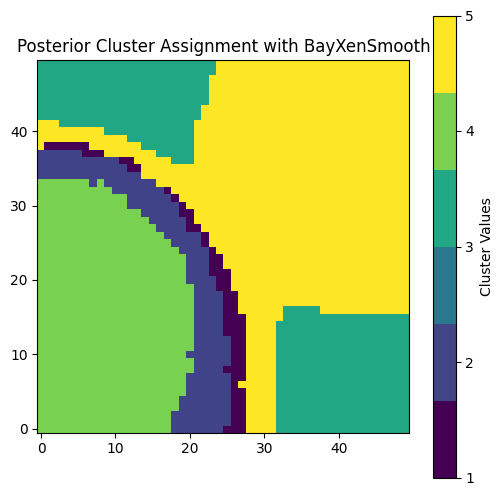

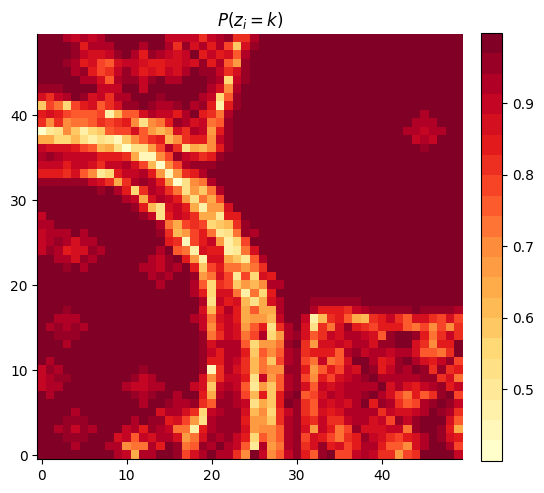

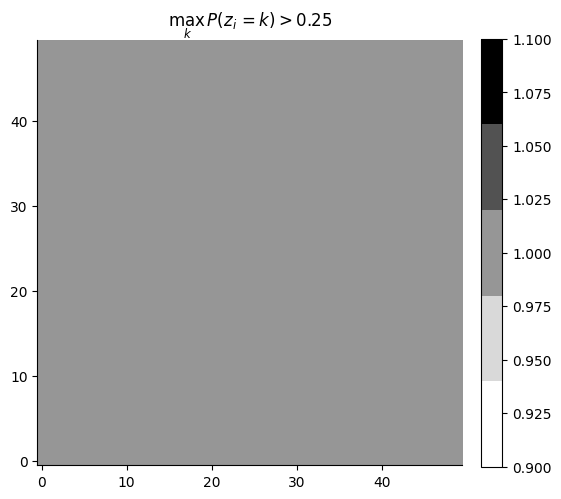

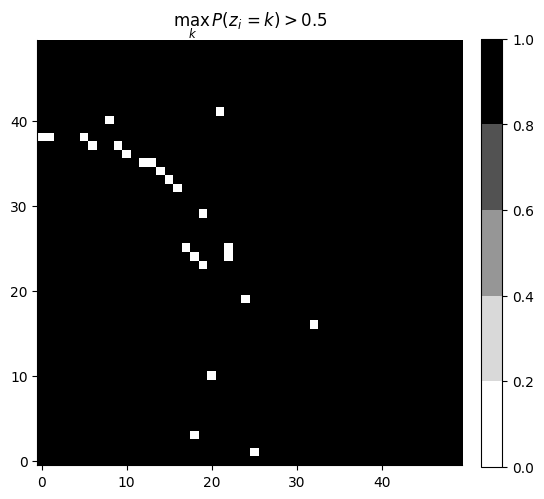

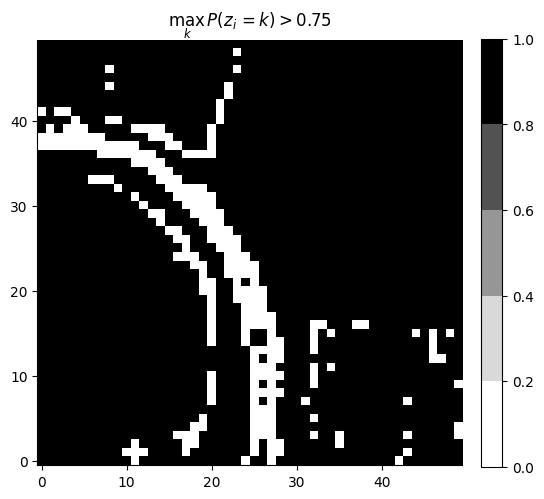

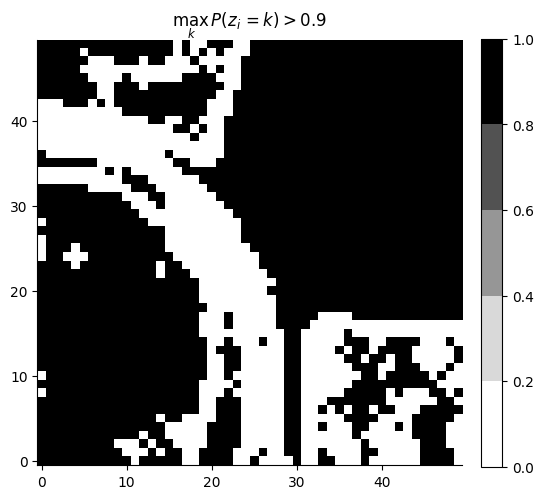

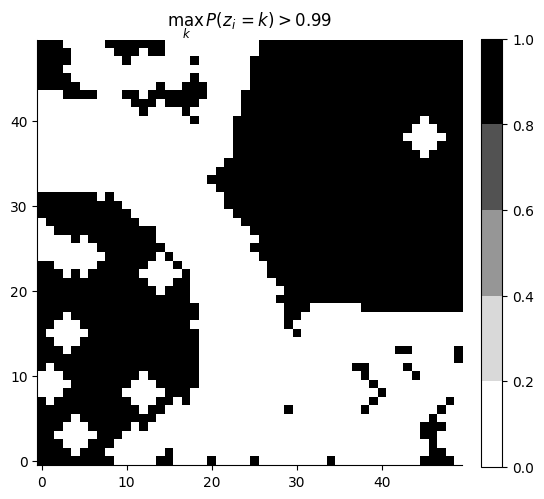

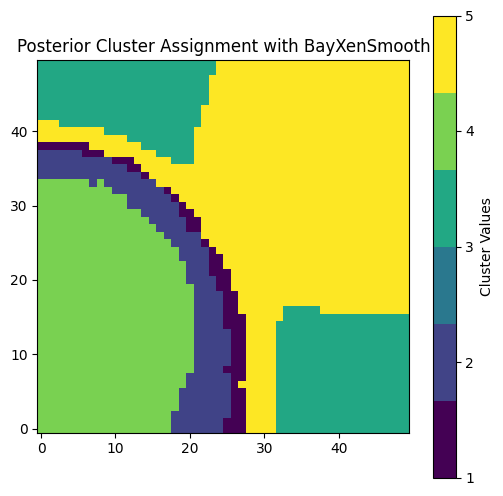

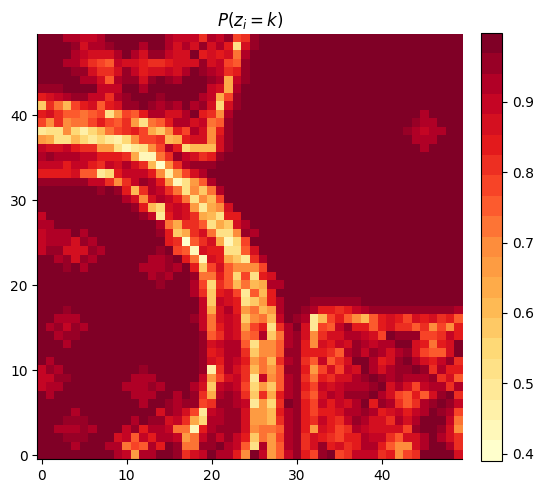

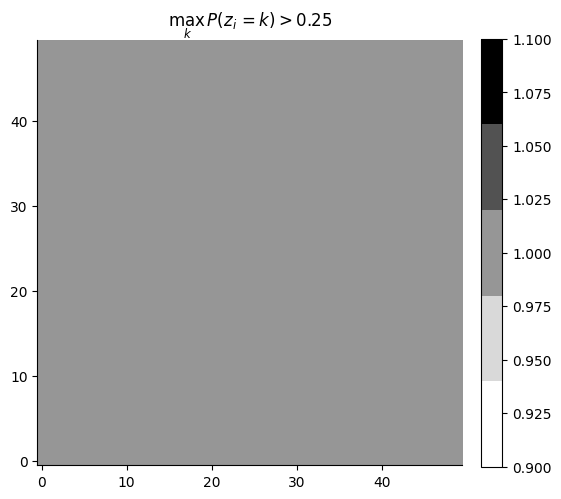

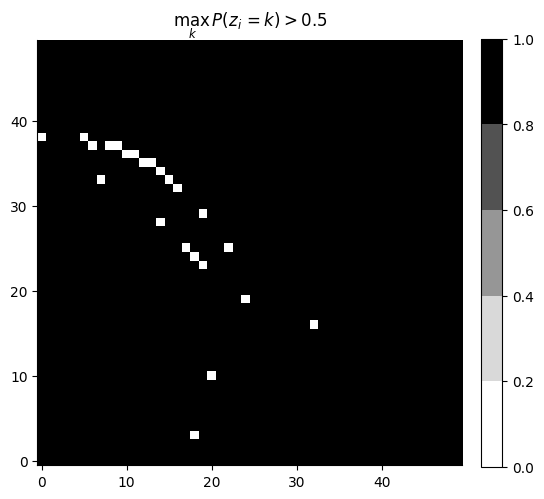

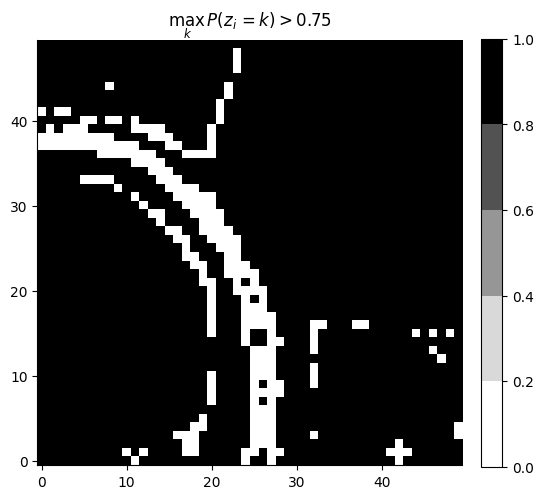

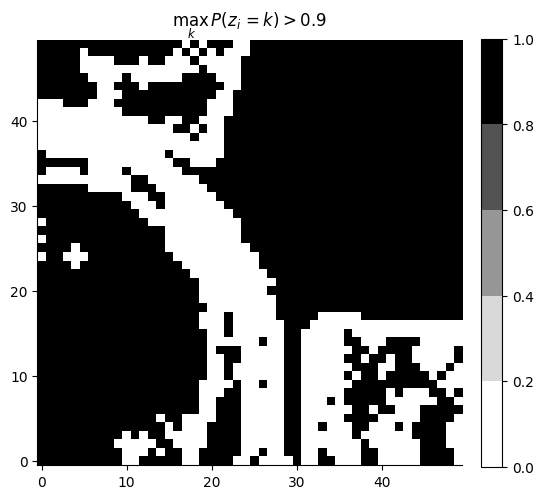

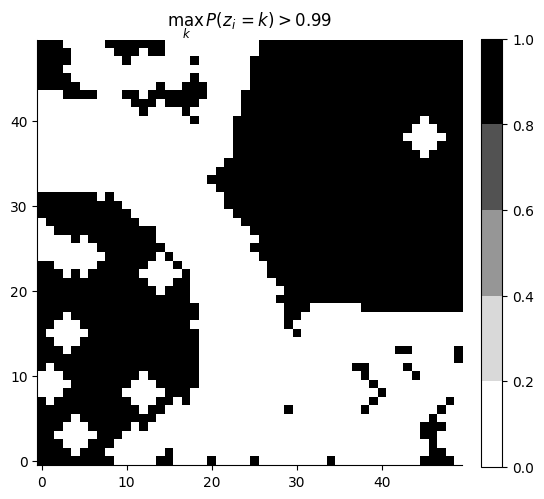

In [20]:
torch.set_default_tensor_type(torch.FloatTensor)

# Grab the learned variational parameters
num_posterior_samples = 1000
sample_for_assignment_options = [True, False]

for sample_for_assignment in sample_for_assignment_options:
    cluster_logits_q_mean = pyro.param("cluster_logits_q_mean")
    cluster_logits_q_scale = pyro.param("cluster_logits_q_scale")
    if sample_for_assignment:
        cluster_probs_q = torch.softmax(pyro.sample("cluster_probs", dist.Normal(cluster_logits_q_mean, cluster_logits_q_scale).expand_by([num_posterior_samples]).to_event(1)).mean(dim=0), dim=-1)
        cluster_assignments_q = pyro.sample("cluster_assignments", dist.Categorical(cluster_probs_q).expand_by([num_posterior_samples])).mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_probs_q = torch.softmax(cluster_logits_q_mean, dim=-1)
        cluster_assignments_q = cluster_probs_q.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE
    
    cluster_means_q_mean = pyro.param("cluster_means_q_mean").cpu().detach()
    cluster_scales_q_mean = pyro.param("cluster_scales_q_mean").cpu().detach()
    cluster_probs_q = cluster_probs_q.cpu().detach()
    cluster_assignments_q = cluster_assignments_q.cpu().detach()
    cluster_assignments_prior = cluster_assignments_prior.cpu().detach()

    # Plotting
    if spot_size:

        rows = spatial_locations["row"].astype(int)
        columns = spatial_locations["col"].astype(int)

        num_rows = max(rows) + 1
        num_cols = max(columns) + 1

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

        cluster_grid[rows, columns] = cluster_assignments_q + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colors, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(1, num_clusters + 1), label='Cluster Values')
        plt.title('Posterior Cluster Assignment with BayXenSmooth')

        match data_mode:
            case "PCA":
                data_file_path = f"{data_mode}/{num_pcs}"
            case "HVG": 
                data_file_path = f"{data_mode}/{hvg_var_prop}"
            case "ALL":
                data_file_path = f"{data_mode}"
            case _:
                raise ValueError("The data mode specified is not supported.")

        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )

        clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"]).to_csv(f"{bayxensmooth_clusters_filepath}/clusters_K={num_clusters}.csv")
        soft_clusters = pd.DataFrame(cluster_probs_q, columns=[f'P(z_i = {i})'  for i in range(1, num_clusters + 1)]).to_csv(f"{bayxensmooth_clusters_filepath}/soft_clusters_K={num_clusters}.csv")

        if not os.path.exists(bayxensmooth_similar_filepath := save_filepath("BayXenSmooth", "prior_v_posterior", sample_for_assignment)):
            os.makedirs(bayxensmooth_similar_filepath)
        with open(f"{bayxensmooth_similar_filepath}/similarity.txt", 'w') as fp:
            prior_similarity = torch.mean((cluster_assignments_prior == cluster_assignments_q).float()).item()
            fp.write(str(prior_similarity))
            print(prior_similarity)

        # grab the mpd distance of cluster labels
        mpd = {}
        for label in range(1, num_clusters + 1):
            current_cluster_locations = torch.stack(torch.where((cluster_grid.cpu() == label)), axis=1).to(float)
            mpd[f"Cluster {label}"] = spot_size * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
        print("mpd", sum(mpd.values()) / 1_000_000)

        if not os.path.exists(bayxensmooth_mpd_filepath := save_filepath("BayXenSmooth", "mpd", sample_for_assignment)):
            os.makedirs(bayxensmooth_mpd_filepath)
        with open(f"{bayxensmooth_mpd_filepath}/mpd.json", 'w') as fp:
            json.dump(mpd, fp)

        cmap = get_cmap('rainbow')

        if isinstance(original_adata.xenium_spot_data.X, csr_matrix):
            labels = np.unique(cluster_assignments_q)  # Define the number of clusters
            gene_columns = original_adata.xenium_spot_data.var.index  # Column names from another source
            mean_expression_by_cluster = pd.DataFrame(columns=gene_columns)

            # Loop through each cluster label
            for label in labels:
                # Find indexes of current cluster
                current_cluster_indexes = torch.where(cluster_assignments_q == label)[0].numpy()
                
                # Efficiently extract the rows for the current cluster using fancy indexing
                expressions = original_adata.xenium_spot_data.X[current_cluster_indexes, :]
                print(label, expressions.shape)
                
                # Compute mean expressions; the result is still a csr_matrix
                mean_expressions = expressions.mean(axis=0)
                
                # Convert mean_expressions to a dense format and then to a DataFrame
                mean_expressions_df = pd.DataFrame(mean_expressions.A, columns=gene_columns)
                
                # Append the result to the mean_expression_by_cluster DataFrame
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions_df], ignore_index=True)
        else:
            # identify marker genes within each cluster
            mean_expression_by_cluster = pd.DataFrame(columns=original_adata.xenium_spot_data.var.index)

            for label in range(num_clusters):
                current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0].cpu().numpy())
                expressions = pd.DataFrame(original_adata.xenium_spot_data.X, columns=original_adata.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
                mean_expressions = expressions.mean(axis=0).to_frame().T
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

        if evaluate_markers:
            for i, gene in enumerate(mean_expression_by_cluster.columns):
                # using subplots() to draw vertical lines 
                fig, ax = plt.subplots(figsize=(6, 6)) 
                ax.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                
                # drawing the markers
                ax.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                ax.set_ylim(0) 
                
                # formatting and details 
                ax.set_xlabel('Cluster Label') 
                ax.set_ylabel('Mean Expression') 
                ax.set_title(gene) 
                ax.set_xticks(mean_expression_by_cluster[gene].index) 
                if not os.path.exists(bayxensmooth_expression_filepath := save_filepath("BayXenSmooth", "expressions", sample_for_assignment)):
                    os.makedirs(f"{bayxensmooth_expression_filepath}")
                _ = plt.savefig(
                    f"{bayxensmooth_expression_filepath}/GENE={gene}.png"
                )
        
        # confidence mapping
        cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.double)

        cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

        heatmap_bins = 21
        colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_confidences, cmap=colors, interpolation='nearest', origin='lower')
        # plt.xticks([])  # Remove x-axis tick marks
        # plt.yticks([])  # Remove y-axis tick marks
        plt.gca().spines['top'].set_visible(False)  # Remove top border
        plt.gca().spines['right'].set_visible(False)  # Remove right border
        # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
        # plt.gca().spines['left'].set_visible(False)  # Remove left border
        cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
        plt.title(r'$P(z_i = k)$')


        colors = plt.cm.get_cmap('Greys', num_clusters)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters)))

        confidence_proportions = {}
        for uncertainty_value in uncertainty_values:
            confidence_matrix = (cluster_confidences > uncertainty_value).float()
            confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
            plt.figure(figsize=(6, 6))
            plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
            # plt.xticks([])  # Remove x-axis tick marks
            # plt.yticks([])  # Remove y-axis tick marks
            plt.gca().spines['top'].set_visible(False)  # Remove top border
            plt.gca().spines['right'].set_visible(False)  # Remove right border
            # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
            # plt.gca().spines['left'].set_visible(False)  # Remove left border
            cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
            # PLOT ALL UNCERTAINTY VALUESs
            plt.title(r'$\max_k \, P(z_i = k) > $' + f'{uncertainty_value}')
            if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
                os.makedirs(bayxensmooth_uncertainty_filepath)
            _ = plt.savefig(
                f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
            )

    else:

        plt.scatter(spatial_locations["x_location"], spatial_locations["y_location"], s=1, c=cluster_assignments_q)
        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )

In [21]:
# KL Calculation
CLAMP = 0.000001
cluster_probs_prior = cluster_probs_prior.cpu().detach().clamp(CLAMP)
TRUE_WEIGHTS = torch.tensor(TRUE_WEIGHTS).clamp(CLAMP)
kl_prior_divergence = torch.sum(TRUE_WEIGHTS * torch.log(TRUE_WEIGHTS / cluster_probs_prior), dim=1)
kl_post_divergence = torch.sum(TRUE_WEIGHTS * torch.log(TRUE_WEIGHTS / cluster_probs_q), dim=1)
kl_prior_divergence.mean(), kl_post_divergence.mean()

(tensor(13.6704, dtype=torch.float64), tensor(6.9713, dtype=torch.float64))

In [22]:
ARI(cluster_assignments_q, TRUE_ASSIGNMENTS)

0.9803063251909218

Text(0.5, 1.0, '$\\max_k P(z_i = k)$')

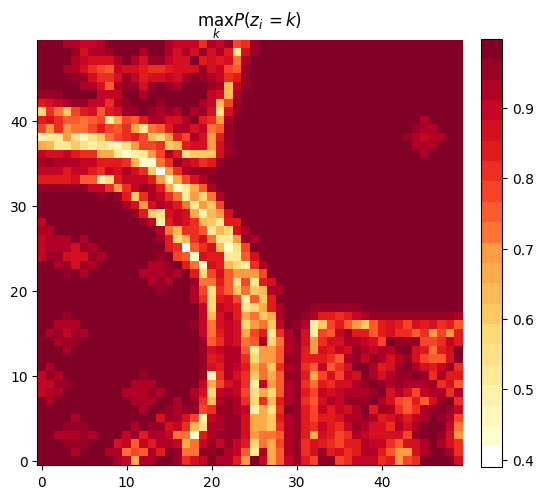

In [23]:
heatmap_bins = 21
colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_confidences, cmap=colormap, interpolation='nearest', origin='lower')
# plt.xticks([])  # Remove x-axis tick marks
# plt.yticks([])  # Remove y-axis tick marks
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
# plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
# plt.gca().spines['left'].set_visible(False)  # Remove left border
cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
plt.title(r'$\max_k P(z_i = k)$')

# confidence_proportions = {}
# for uncertainty_value in uncertainty_values:
#     confidence_matrix = (cluster_confidences > uncertainty_value).float()
#     confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
#     plt.figure(figsize=(6, 6))
#     plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
#     plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
#     # PLOT ALL UNCERTAINTY VALUESs
#     plt.title(r'$P(z_i = k) > $' + f'{uncertainty_value}')
#     if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
#         os.makedirs(bayxensmooth_uncertainty_filepath)
#     _ = plt.savefig(
#         f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
#     )

Proportion of Same Labels: 0.9416000247001648


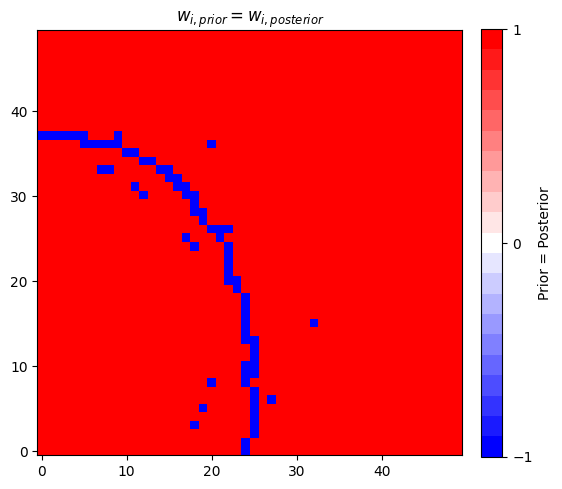

In [24]:
plt.figure(figsize=(6, 6))
same_labels = (cluster_grid_PRIOR.cpu() == cluster_grid.cpu()).float() * 2 - 1
same_labels[cluster_grid_PRIOR.cpu() == 0] = 0
colors = plt.cm.get_cmap('bwr', heatmap_bins)
plt.imshow(same_labels, cmap=colors, interpolation='nearest', origin='lower')
plt.colorbar(ticks=[-1,0,1], label='Prior = Posterior', fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
print(f"Proportion of Same Labels: {same_labels.float().mean()}")
_ = plt.title(r'$w_{i, prior} = w_{i, posterior}$')